# 1. Introduction

This project demonstrates the development of a cutting-edge OCR (Optical Character Recognition) model powered by GPT-4 with Vision and the LangChain framework. The goal is to process receipt images and transform them into structured JSON outputs tailored to custom-defined formats. By leveraging advanced LLM capabilities, the project not only extracts text but also understands and organizes it into meaningful, structured data for automatic expense management.

This notebook builds upon an earlier hackathon project and serves as an end-to-end demo. It provides a step-by-step guide to replicating and extending the solution, covering preprocessing, OCR extraction, receipt parsing, and customizable JSON output generation. The project highlights the integration of modern AI frameworks, enabling scalability and adaptability for real-world applications.

# **2. Dependency setup & API Configuration**

In [ ]:
  # !pip install langchainhub langchain langchain-openai beautifulsoup4 faiss-cpu
  # !pip install langchain-chroma
  # !pip install langchain-community
  # !pip install jq
  # !pip install langchain openai
  # !pip install opencv-python pillow numpy
  # !pip install paddleocr
  # !pip install easyocr

In [ ]:
## mount to the google drive since the receipt data is saved there
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# list all files in MyDrive to confirm
!ls /content/drive/MyDrive/

'Colab Notebooks'   data   deep-learning_udacity_repo   Other   resumes


In [ ]:
import os
import langchain
from langchain.chains import TransformChain
import base64
from PIL import Image
from IPython.display import Image as displayImage, display

# List all files and directories in your Google Drive
notebook_folder = '/content/drive/MyDrive/Colab Notebooks/coupa hackathon (Aug 2024)/'
data_folder = '/content/drive/MyDrive/Colab Notebooks/coupa hackathon (Aug 2024)/Receipts'

print(os.listdir(notebook_folder))

['expense_category_list.zip', 'Receipts', 'CD-Receipt OCR Enhancement with LLM-110824-212158.pdf', 'Receipts and Expense Examples.gsheet', 'expense_category_list.xlsx', 'Prompt Enginnering.gdoc', 'category_definitions.txt', 'hackathon_coupa_receipt_to_expense_report.zip', 'coupa_hackathon_playaround_v1.ipynb', '.ipynb_checkpoints', 'Copy of aiko_receipt_parser_playground.ipynb']


In [ ]:
from google.colab import userdata

os.environ['AZURE_OPENAI_API_KEY'] = userdata.get('coupa-azure-gpt-4o-api-key') ## i added the API key into colab secret, but free to replace it with your key
os.environ['AZURE_OPENAI_ENDPOINT'] = "https://genai-dev-coupadev-eastus.openai.azure.com"
os.environ["API_VERSION"] = "2024-08-01-preview"

os.chdir(notebook_folder)

# List files in the current directory (where your notebook is)
print(os.listdir('.'))

['expense_category_list.zip', 'Receipts', 'CD-Receipt OCR Enhancement with LLM-110824-212158.pdf', 'Receipts and Expense Examples.gsheet', 'expense_category_list.xlsx', 'Prompt Enginnering.gdoc', 'category_definitions.txt', 'hackathon_coupa_receipt_to_expense_report.zip', 'coupa_hackathon_playaround_v1.ipynb', '.ipynb_checkpoints', 'aiko_receipt_parser_playground_v2.ipynb']


In [ ]:
import os
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    azure_deployment="gpt-4o-2024-08-06",  # or your deployment
    api_version=os.environ["API_VERSION"],  # or your api version
    temperature=0.0,
    max_tokens=None,
    timeout=None,
    max_retries=2
)

# verify if the key works:
# messages = [
#    (
#        "system",
#        "You are a helpful assistant that translates English to French. Translate the user sentence.",
#    ),
#    ("human", "I love programming."),
# ]
# ai_msg = llm.invoke(messages)
# ai_msg

# **3. Receipt Image Pre-processing**

## 3.1. Given the following receipt

In [ ]:
from IPython.display import Image as displayImage, display
raw_image_path = "Receipts/Midland_Airport_23.58.jpg"
display(displayImage(filename=raw_image_path))

Output hidden; open in https://colab.research.google.com to view.

## 3.2. Receipt Image Augmentation

Orientation corrected
Enhanced the raw image, saved as Receipts/enhanced_Midland_Airport_23.58.jpg, with size of 0.66 MB


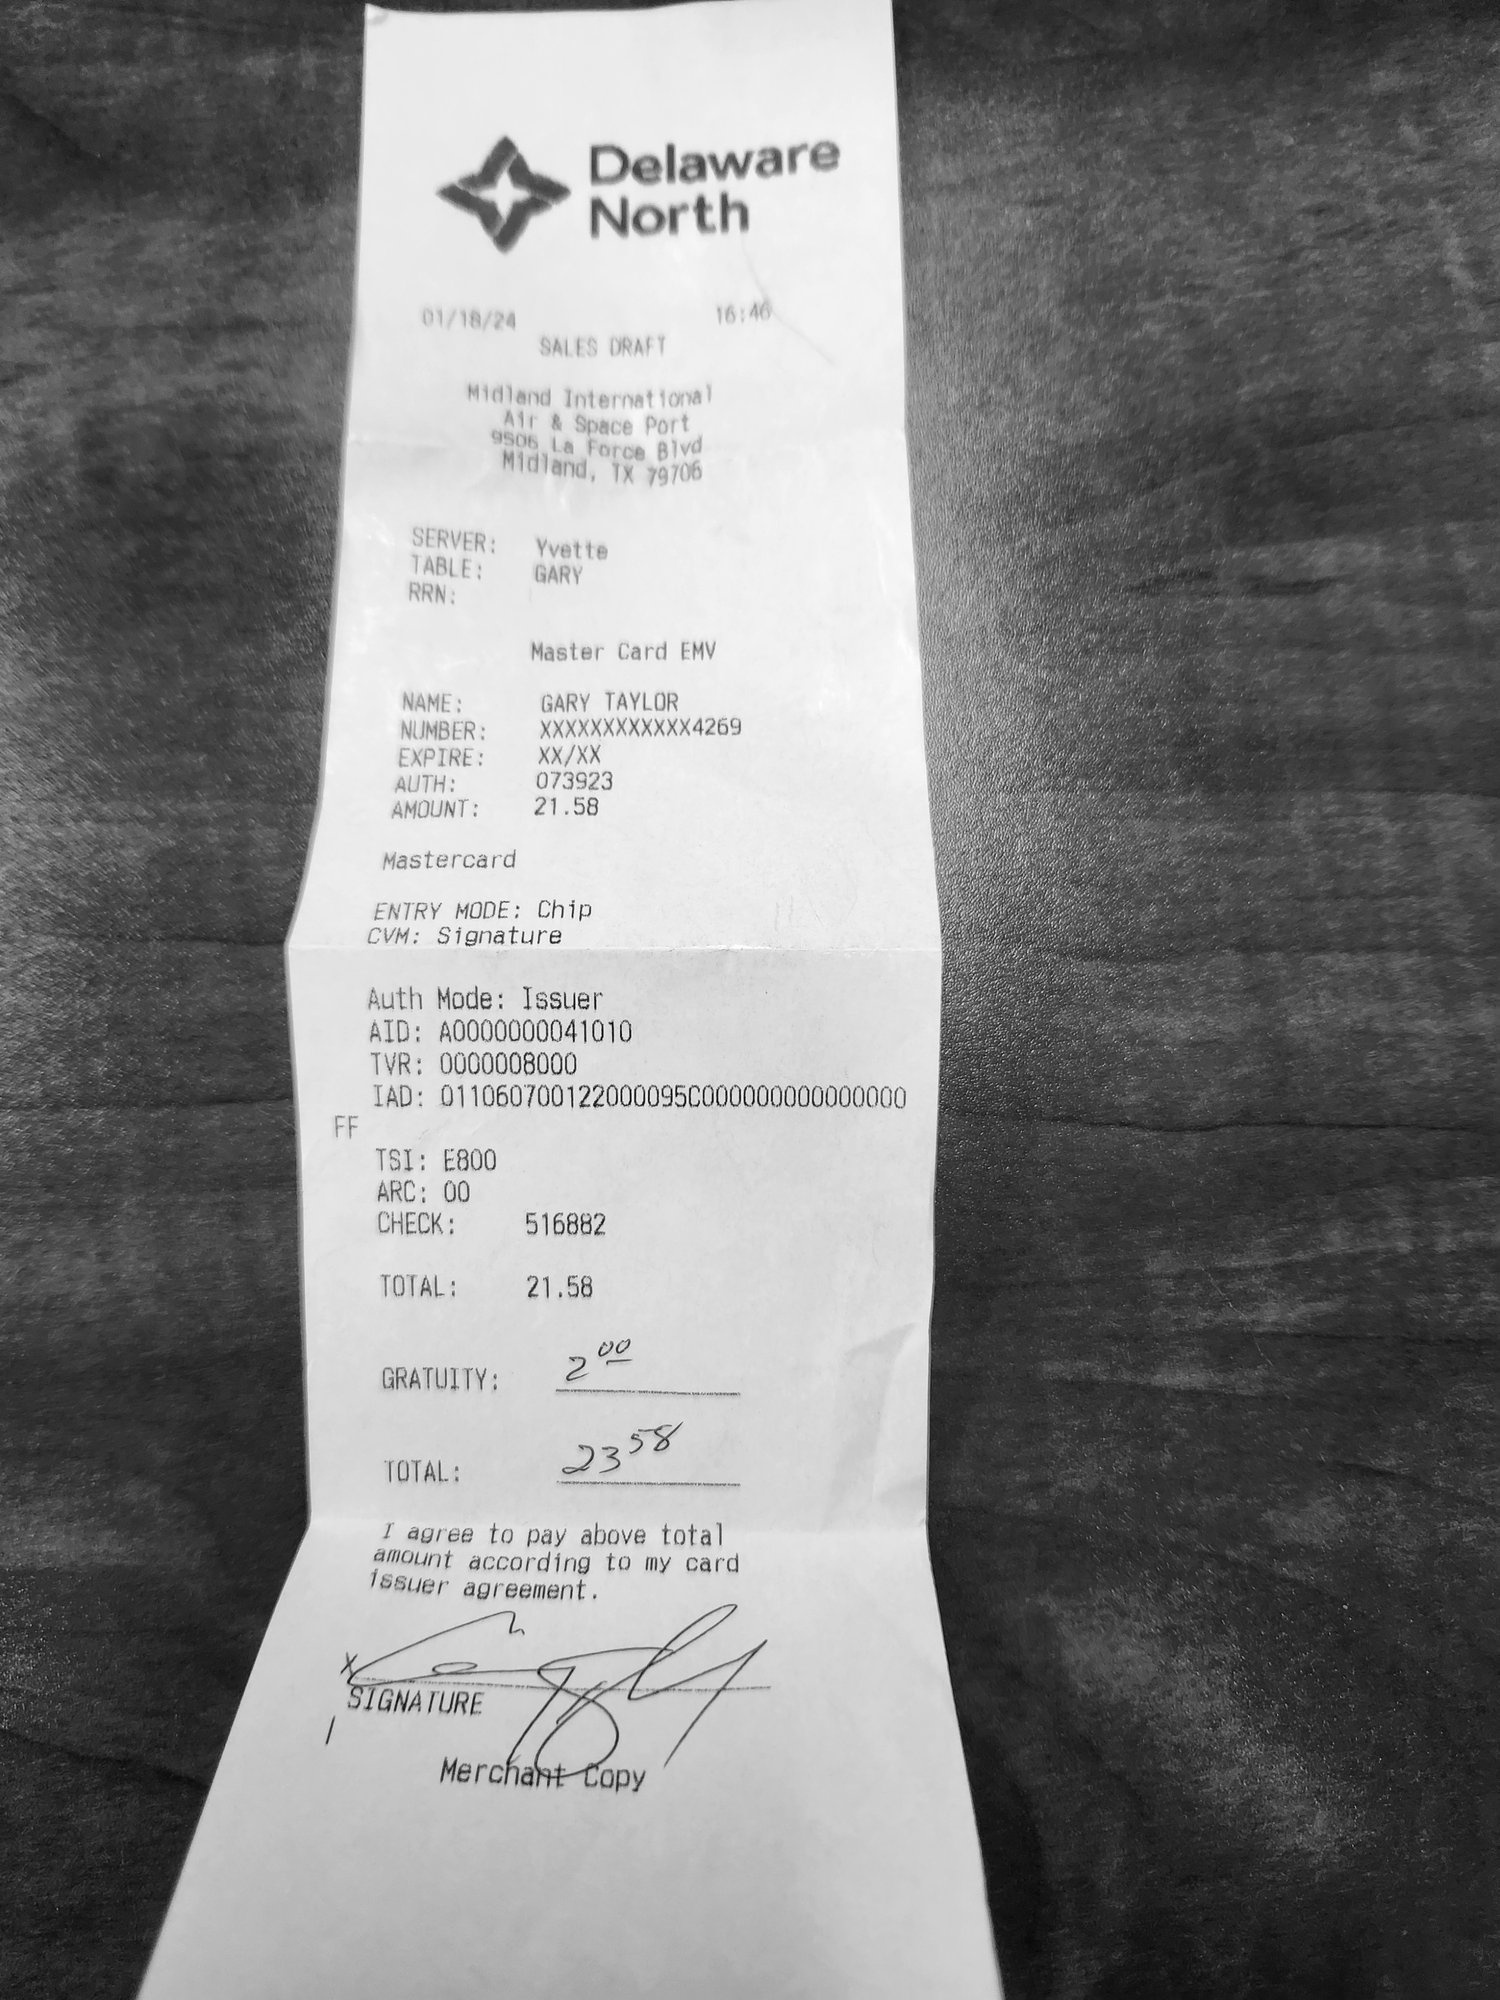

In [ ]:
import os
from PIL import Image, ExifTags
import cv2

def preprocess_image(image_path):
    """Preprocess the image by converting it to grayscale."""
    # Read the image
    image = cv2.imread(image_path)
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray

def get_file_size(image_path):
    """Get the file size in megabytes (MB)."""
    return os.path.getsize(image_path) / (1024 * 1024)

def correct_orientation(img):
    """Corrects the orientation of the image based on EXIF data."""
    try:
        # Get EXIF data
        exif = img._getexif()
        if exif is not None:
            for tag, value in exif.items():
                if tag in ExifTags.TAGS and ExifTags.TAGS[tag] == "Orientation":
                    if value == 3:
                        img = img.rotate(180, expand=True)
                    elif value == 6:
                        img = img.rotate(270, expand=True)
                    elif value == 8:
                        img = img.rotate(90, expand=True)
                    print("Orientation corrected")
                    break
    except (AttributeError, KeyError, IndexError):
        # If no EXIF data or no orientation tag, do nothing
        pass
    return img

def augment_image(image_path, max_size_mb=2, target_resolution=(1500, 1500)):
    """
    Enhance and preprocess an image: correct orientation, resize, convert to grayscale,
    and output a single enhanced file.
    """
    with Image.open(image_path) as img:
        # Correct orientation
        img = correct_orientation(img)

        # Ensure the image is in RGB format (convert if necessary)
        if img.mode == "RGBA":
            img = img.convert("RGB")
            print("Converted RGBA to RGB for compatibility with JPEG format")

        # Resize the image while maintaining aspect ratio
        width, height = img.size
        aspect_ratio = width / height
        new_width = target_resolution[0]
        new_height = int(new_width / aspect_ratio)
        img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)

        # Save the resized image temporarily
        temp_path = "temp_resized_image.jpg"
        img.save(temp_path, format="JPEG", quality=85)

    # Apply preprocessing (grayscale conversion)
    gray_image = preprocess_image(temp_path)

    # Save the final enhanced image
    directory, filename = os.path.split(image_path)
    output_path = os.path.join(directory, "enhanced_" + filename)
    cv2.imwrite(output_path, gray_image)

    # Clean up temporary file
    if os.path.exists(temp_path):
        os.remove(temp_path)

    print(f"Enhanced the raw image, saved as {output_path}, with size of {get_file_size(output_path):.2f} MB")
    return output_path

augmented_image_path = augment_image("Receipts/Midland_Airport_23.58.jpg")
display(displayImage(filename=augmented_image_path))



# **4. Prepare the chain using LangChain**

To perform the receipt parsing using LLM, our chain is consisted of 3 parts:

load_image_chain | image_model | parser

1.   **load_image_chain**: Image loading and transformation (augmentation and encoding)
2.   **image_model**: LLM invoking using GPT-4o
3.   **parser**: Structural parser to guarantee output is structural, consistant and stable, using Pydantic






## 4.1. load_image_chain

Image loading and transformation (augmentation and encoding)

In [ ]:
from langchain.chains import TransformChain
def load_image(inputs: dict) -> dict:
    """Load image from file and encode it as base64."""
    image_path = inputs["image_path"]

    def encode_image(image_path):

        ## augment the image before encoding
        image_path_after_resizing = augment_image(image_path)

        with open(image_path_after_resizing, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')
    image_base64 = encode_image(image_path)
    return {"image": image_base64}

load_image_chain = TransformChain(
    input_variables=["image_path"],
    output_variables=["image"],
    transform=load_image
)

## example usage:
# inputs = {"image_path": "Receipts/Midland_Airport_23.58.jpg"}
# image_data = load_image(inputs)['image']

## 4.2. structual json parser

Structural parser to guarantee output is structural, consistant and stable, using Pydantic

In [ ]:
## here we use pydantic to simplicity, but Azure seems to have own structual parser:
# https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/structured-outputs?tabs=python-secure

from pydantic import BaseModel, Field
from typing import Tuple
from langchain_core.output_parsers import JsonOutputParser

class ExpenseReceiptImageInformation(BaseModel):
 """Information about an expense receipt image."""
 transaction_date: Tuple[str, str] = Field(description="date of the expense with confidence level")
 total_amount: Tuple[float, str] = Field(description="total amount of expense on this receipt including tax with confidence level")
 tax_amount: Tuple[float, str] = Field(description="amount of tax for this expense with confidence level")
 currency: Tuple[str, str] = Field(description="currency of the expense with confidence level")
 merchant: Tuple[str, str] = Field(description="name of the merchant with confidence level")
 merchant_location: Tuple[str, str] = Field(description="address of of merchant of the receipt if written; if not, then the city / state of the merchant with confidence level")
 expense_summary: Tuple[str, str] = Field(description="a short description of this expense on receipt image with confidence level")
 expense_category: Tuple[str, str] = Field(description="predicted expense category based on the receipt with confidence level")


parser = JsonOutputParser(pydantic_object=ExpenseReceiptImageInformation)

## 4.3. image_model
LLM invoking using GPT-4o vision model

In [ ]:
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import AzureChatOpenAI
from langchain.document_loaders import TextLoader

category_definitions_file_path = 'category_definitions.txt'
## we could upload custom defined categories definition to our chain for RAG purpose (retrieval augmented generation)
def load_category_definitions() -> str:
    """Load content from an external category definitions file."""
    loader = TextLoader(file_path=category_definitions_file_path)
    return loader.load()[0].page_content

def image_model(inputs: dict) -> dict:
    """Invoke an image model to extract receipt details based on prompts."""
    # Validate inputs
    image_data = inputs.get("image")
    if not image_data:
        raise ValueError("Missing required input: 'image_data'.")

    # Initialize LLM model
    llm = AzureChatOpenAI(
        azure_deployment="gpt-4o-2024-08-06",
        api_version=os.getenv("API_VERSION"),  # Default to a specific version
        temperature=0.0,
        max_tokens=None,
        timeout=None,
        max_retries=2,
    )

    # System-level instructions
    system_prompt = """
    You are an OCR parser. Your goal is to accurately extract details from a receipt image.
    Follow these rules:
    - Do not guess or improvise. If unsure about a field, leave it blank.
    - Do not
    """

    # Task-specific vision prompt
    vision_prompt = """
    Given the image of an expense receipt, extract the following details in JSON format. Each field should include its confidence level as [HIGH, MEDIUM, LOW].
      Return the response as JSON with the following keys:
      - "transaction_date": ["MM/DD/YYYY", "confidence_level"]
      - "total_amount": [total amount including tax and gratuity, "confidence_level"]
      - "tax_amount": [tax amount, "confidence_level"]
      - "currency": [currency symbol, "confidence_level"]
      - "merchant": [merchant name, "confidence_level"]
      - "merchant_location": [merchant address or city, "confidence_level"]
      - "expense_summary": [short description on the expense within 10 words, "confidence_level"]
      - "expense_category": [select the most suitable expense category from the given categories definitions, "confidence_level"]

      Example:
      {
        "transaction_date": ["04/11/2024", "HIGH"],
        "total_amount": [15.8, "MEDIUM"],
        "tax_amount": [1.62, "LOW"],
        "currency": ["$", "HIGH"],
        "merchant": ["mcdonald's", "MEDIUM"],
        "merchant_location": ["40 NE 144th St, Kirkland, WA", "LOW"],
        "expense_summary": ["lunch meal in mcdonald's on 04/11/2024", "MEDIUM"],
        "expense_category" : ["Meal-Lunch", "LOW")]
      }
    """
    category_definitions = load_category_definitions()

    category_definitions_prompt = f"""categories are defined: {category_definitions}"""

    # Create message objects
    system_message = SystemMessage(content=system_prompt)
    human_message = HumanMessage(
        content=[
            {"type": "text", "text": vision_prompt + category_definitions_prompt},
            {"type": "text", "text": parser.get_format_instructions()},
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image_data}"},
            },
        ]
    )

    # Invoke the model and handle response
    try:
        ai_msg = llm.invoke([system_message, human_message])
        return ai_msg.content
    except Exception as e:
        return {"status": "error", "error_message": str(e)}

# **5. Finally, we combine above 3 steps into a Chain:**

In [ ]:
def receipt_parsing(image_path: str) -> dict:
  vision_chain = load_image_chain | image_model | parser
  return vision_chain.invoke({"image_path": image_path})


In [ ]:
result = receipt_parsing("Receipts/Midland_Airport_23.58.jpg")
result

Orientation corrected
Enhanced the raw image, saved as Receipts/enhanced_Midland_Airport_23.58.jpg, with size of 0.66 MB


{'transaction_date': ['01/18/2024', 'HIGH'],
 'total_amount': [23.58, 'HIGH'],
 'tax_amount': [0.0, 'LOW'],
 'currency': ['$', 'MEDIUM'],
 'merchant': ['Delaware North', 'HIGH'],
 'merchant_location': ['Midland, TX 79706', 'HIGH'],
 'expense_summary': ['meal at Delaware North', 'MEDIUM'],
 'expense_category': ['Meal-Dinner', 'MEDIUM']}

In [ ]:
result

{'transaction_date': ['01/18/2024', 'HIGH'],
 'total_amount': [21.58, 'HIGH'],
 'tax_amount': [0.0, 'LOW'],
 'currency': ['$', 'MEDIUM'],
 'merchant': ['Delaware North', 'HIGH'],
 'merchant_location': ['Midland, TX 79706', 'HIGH'],
 'expense_summary': ['meal at Delaware North', 'MEDIUM'],
 'expense_category': ['Meal-Dinner', 'LOW']}

# **6. Evaluation**

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Get all files in the evaluation receipts folder (randomly pick 10 receipts)
image_paths = [
    os.path.join("evaluation_receipts", filename)
    for filename in os.listdir("evaluation_receipts")
    if filename.lower().endswith(('.png', '.jpg', '.jpeg'))  # Filter for image files
]

# Grid size
rows = len(image_paths)
cols = 2  # Image on left, prediction on right

# Create the figure with custom width ratios (e.g., left column 6x the size of the right column)
fig, axes = plt.subplots(
    rows, cols, figsize=(32, 15 * rows),  # Adjust figure size based on the number of images (wider figure)
    gridspec_kw={'width_ratios': [15, 1]}  # Allocate 6 times more space to the left column
)
axes = axes.flatten()

# Process each image
for idx, image_path in enumerate(image_paths):
    # Parse the receipt
    result = receipt_parsing(image_path)

    # Load and prepare the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for displaying

    # Display the receipt image
    axes[idx * 2].imshow(image)
    axes[idx * 2].axis('off')  # Hide axes
    axes[idx * 2].set_title(f"Receipt {idx+1}", fontsize=12)

    # Prepare the parsed text in a readable format
    parsed_text = "\n".join([f"{key.replace('_', ' ').title()}: {value[0]} (Confidence: {value[1]})"
                            for key, value in result.items()])

    # Limit the vertical size of the text box
    axes[idx * 2 + 1].text(
        0, 1, parsed_text, ha='left', va='top', fontsize=12, wrap=True, family="monospace",
        transform=axes[idx * 2 + 1].transAxes  # Relative positioning within the axes
    )
    axes[idx * 2 + 1].axis('off')  # Hide axes
    axes[idx * 2 + 1].set_title(f"Prediction {idx+1}", fontsize=12)

# Adjust layout to ensure no overlap and maximize space
plt.tight_layout(pad=3.0)  # Add padding between the subplots to reduce space

# # Adjust layout
# plt.tight_layout()
plt.show()


Enhanced the raw image, saved as evaluation_receipts/enhanced_IMG_9811.jpg, with size of 0.52 MB
Orientation corrected
Enhanced the raw image, saved as evaluation_receipts/enhanced_image_123650291_(1).JPG, with size of 0.25 MB
Orientation corrected
Enhanced the raw image, saved as evaluation_receipts/enhanced_image_123650291.JPG, with size of 0.25 MB
Orientation corrected
Enhanced the raw image, saved as evaluation_receipts/enhanced_image_123650291_(1) (1).JPG, with size of 0.25 MB
Orientation corrected
Enhanced the raw image, saved as evaluation_receipts/enhanced_IMG_8791.jpg, with size of 0.98 MB
Orientation corrected
Enhanced the raw image, saved as evaluation_receipts/enhanced_Midland_Airport_23.58.jpg, with size of 0.66 MB
Orientation corrected
Enhanced the raw image, saved as evaluation_receipts/enhanced_IMG_0102.jpg, with size of 1.02 MB
Orientation corrected
Enhanced the raw image, saved as evaluation_receipts/enhanced_image (2).jpg, with size of 0.67 MB
Orientation corrected
E

# **7. Further Improvements**

## Improvement 1: add OCR text into input prompt part, along with the the image url

*   pros: additional instruction to further enhance accuracy
*   cons: extra cost/latency on OCR part

In [ ]:
## improvement 1: add OCR test into input prompt part, along with the the image url
# from paddleocr import PaddleOCR

# # Initialize PaddleOCR
# ocr = PaddleOCR(use_angle_cls=True, lang='en')  # Supports multiple languages

# # Perform OCR
# image_path = 'example_image.jpg'
# result = ocr.ocr(image_path, cls=True)

# # Display results
# for line in result[0]:
#     print(f"Detected text: {line[1][0]} (Confidence: {line[1][1]})")

## improvement 2: crop the image to only include the bounding box containing the text information

*   pros: OCR accuracy could be further improved in some cases, when the background has lots of noises
*   cons: runtime inference using CPU is pretty slow; in production, we might need to invoke this part using CUDA / GPU if needed

In [ ]:
import easyocr
import cv2

def crop_receipt(image_path, output_path="cropped_receipt.jpg"):
    # Initialize EasyOCR reader
    reader = easyocr.Reader(['en'])

    # Read the image
    image = cv2.imread(image_path)

    # Perform OCR and get bounding boxes
    results = reader.readtext(image_path, detail=1)  # detail=1 returns bounding boxes

    # Extract bounding boxes
    text_boxes = [result[0] for result in results]  # result[0] contains bbox

    # Find the overall bounding box that includes all text
    x_min = min([box[0][0] for box in text_boxes])
    y_min = min([box[0][1] for box in text_boxes])
    x_max = max([box[2][0] for box in text_boxes])
    y_max = max([box[2][1] for box in text_boxes])

    # Crop the image to the bounding box
    cropped_image = image[int(y_min):int(y_max), int(x_min):int(x_max)]

    # Save or return the cropped image
    cv2.imwrite(output_path, cropped_image)
    return cropped_image

# Example usage
image_path = 'Receipts/enhanced_image.jpg'
cropped_image = crop_receipt(image_path)


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete